In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import re
import nltk
import pickle
import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

In [5]:
df_labeled = pd.read_csv('/content/drive/MyDrive/labeled_data.csv')
df_twitter = pd.read_csv('/content/drive/MyDrive/train.csv')
df_sexism = pd.read_csv('/content/drive/MyDrive/twitter_sexism_parsed_dataset.csv')
df_racism = pd.read_csv('/content/drive/MyDrive/twitter_racism_parsed_dataset.csv')
df_toxic = pd.read_csv('/content/drive/MyDrive/toxicity_parsed_dataset.csv')
df_aggression = pd.read_csv('/content/drive/MyDrive/attack_parsed_dataset.csv')

In [6]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

Previous Dataset

In [7]:
df_labeled.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace=True)

In [8]:
df_labeled['tweet']=df_labeled['tweet'].apply(clean_text)

In [9]:
df_labeled["class"].replace({0: 1}, inplace=True)

In [10]:
df_labeled["class"].replace({2: 0}, inplace=True)

In [11]:
df_labeled.rename(columns ={'class':'label'}, inplace = True)

In [12]:
df_twitter.drop('id',axis=1,inplace=True)

In [13]:
df_twitter['tweet']=df_twitter['tweet'].apply(clean_text)

Sexism Dataset

In [ ]:
df_sexism.head()
#sexism = 1
#none = 0

,index,id,Text,Annotation,oh_label
0,5.35198627292254E+017,5.35198627292254E+017,RT @BeepsS: @senna1 @BeepsS: I'm not sexist bu...,sexism,1.0
1,5.75984924030714E+017,5.75984924030714E+017,There's some very hate able teams this year #MKR,none,0.0
2,5.7233536016588E+017,5.7233536016588E+017,"RT @The_Eccles: ""Everyone underestimated us"" \...",none,0.0
3,5.72337925708374E+017,5.72337925708374E+017,RT @NOTLukeDarcy: did @Channel7 or #MKR actual...,none,0.0
4,4.43033024528011E+017,4.43033024528011E+017,"No, you don't. @Shut_Up_Jeff: I thought of a r...",sexism,1.0


In [14]:
df_sexism.drop(['index','id','Annotation'],axis=1,inplace=True)

In [ ]:
df_sexism.head()

,Text,oh_label
0,RT @BeepsS: @senna1 @BeepsS: I'm not sexist bu...,1.0
1,There's some very hate able teams this year #MKR,0.0
2,"RT @The_Eccles: ""Everyone underestimated us"" \...",0.0
3,RT @NOTLukeDarcy: did @Channel7 or #MKR actual...,0.0
4,"No, you don't. @Shut_Up_Jeff: I thought of a r...",1.0


In [15]:
df_sexism['Text']=df_sexism['Text'].apply(clean_text)

In [ ]:
df_sexism.head()

,Text,oh_label
0,rt beepss beepss im sexist fuck your woman ca...,1.0
1,there hate abl team year mkr,0.0
2,rt theeccl everyon underestim us still well un...,0.0
3,rt notlukedarci mkr actual check peopl could ...,0.0
4,dont shutupjeff thought realli funni joke prom...,1.0


In [16]:
df_sexism.rename(columns ={'oh_label':'label'}, inplace = True)

In [ ]:
df_sexism.head()

,Text,label
0,rt beepss beepss im sexist fuck your woman ca...,1.0
1,there hate abl team year mkr,0.0
2,rt theeccl everyon underestim us still well un...,0.0
3,rt notlukedarci mkr actual check peopl could ...,0.0
4,dont shutupjeff thought realli funni joke prom...,1.0


In [17]:
df_only_sexism = df_sexism[df_sexism['label']==1]
df_only_sexism

,Text,label
0,rt beepss beepss im sexist fuck your woman ca...,1.0
4,dont shutupjeff thought realli funni joke prom...,1.0
5,rt wateronatrain might like patriarchi,1.0
10,rt metalbarbiedol yea appar gamerg women sock ...,1.0
13,dude go culinari school findawif notsexist,1.0
...,...,...
14862,rt lukeyook think dessert refin beauti wonder ...,1.0
14869,girl claim theyr hot general overinfl view mkr,1.0
14871,rt ursovanilla nikki amp kati didnt love boy t...,1.0
14872,u write urself omg joeldang girl come sign mus...,1.0


In [18]:
df_only_sexism["label"].replace({1: 2}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
df_only_sexism.head()

,Text,label
0,rt beepss beepss im sexist fuck your woman ca...,2.0
4,dont shutupjeff thought realli funni joke prom...,2.0
5,rt wateronatrain might like patriarchi,2.0
10,rt metalbarbiedol yea appar gamerg women sock ...,2.0
13,dude go culinari school findawif notsexist,2.0


In [19]:
df_only_sexism.rename(columns ={'Text':'tweet'}, inplace = True)
df_only_sexism

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,tweet,label
0,rt beepss beepss im sexist fuck your woman ca...,2.0
4,dont shutupjeff thought realli funni joke prom...,2.0
5,rt wateronatrain might like patriarchi,2.0
10,rt metalbarbiedol yea appar gamerg women sock ...,2.0
13,dude go culinari school findawif notsexist,2.0
...,...,...
14862,rt lukeyook think dessert refin beauti wonder ...,2.0
14869,girl claim theyr hot general overinfl view mkr,2.0
14871,rt ursovanilla nikki amp kati didnt love boy t...,2.0
14872,u write urself omg joeldang girl come sign mus...,2.0


Racism

In [20]:
df_racism.head()
#racist = 1
#none = 0

,index,id,Text,Annotation,oh_label
0,5.767493e+17,5.767493e+17,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1
1,5.408905e+17,5.408905e+17,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0
2,5.678433e+17,5.678433e+17,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1
3,5.766462e+17,5.766462e+17,"Finally I'm all caught up, and that sudden dea...",none,0
4,5.713492e+17,5.713492e+17,@carolinesinders @herecomesfran *hugs*,none,0


In [21]:
df_racism.drop(['index','id','Annotation'],axis=1,inplace=True)

In [22]:
df_racism['Text']=df_racism['Text'].apply(clean_text)

In [ ]:
df_racism.head()

,Text,oh_label
0,muslim mob violenc hindus bangladesh continu ...,1
1,,0
2,jncatron israjourisra ampalestin islamophobia ...,1
3,final im caught sudden death cook look like go...,0
4,carolinesind herecomesfran hug,0


In [23]:
df_racism.rename(columns ={'oh_label':'label'}, inplace = True)
df_racism.rename(columns ={'Text':'tweet'}, inplace = True)

In [ ]:
df_racism.head()

,tweet,label
0,muslim mob violenc hindus bangladesh continu ...,1
1,,0
2,jncatron israjourisra ampalestin islamophobia ...,1
3,final im caught sudden death cook look like go...,0
4,carolinesind herecomesfran hug,0


In [24]:
df_only_racism = df_racism[df_racism['label']==1]
df_only_racism

,tweet,label
0,muslim mob violenc hindus bangladesh continu ...,1
2,jncatron israjourisra ampalestin islamophobia ...,1
8,huffpostrelig islam invad conquer christiando...,1
9,semzyxx approv pedophil prophet rape year old...,1
10,geekyzekey problem vile muslim tri ration amp...,1
...,...,...
13401,umarfarooq faheemhus jackmjenkin exampl litera...,1
13418,hope someon cook drasko next ep mkr,1
13419,myth moder islam rebel fanat islam must outlaw,1
13423,loveconcursal ottomanland isi giant embarrass ...,1


In [25]:
df_only_racism["label"].replace({1: 3}, inplace=True)
df_only_racism

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,tweet,label
0,muslim mob violenc hindus bangladesh continu ...,3
2,jncatron israjourisra ampalestin islamophobia ...,3
8,huffpostrelig islam invad conquer christiando...,3
9,semzyxx approv pedophil prophet rape year old...,3
10,geekyzekey problem vile muslim tri ration amp...,3
...,...,...
13401,umarfarooq faheemhus jackmjenkin exampl litera...,3
13418,hope someon cook drasko next ep mkr,3
13419,myth moder islam rebel fanat islam must outlaw,3
13423,loveconcursal ottomanland isi giant embarrass ...,3


In [26]:
frame=[df_twitter,df_labeled,df_only_sexism,df_only_racism]
df_new = pd.concat(frame)

In [ ]:
df_new

,label,tweet
0,0.0,user father dysfunct selfish drag kid dysfunc...
1,0.0,user user thank lyft credit cant use caus dont...
2,0.0,bihday majesti
3,0.0,model love u take u time urð± ððð...
4,0.0,factsguid societi motiv
...,...,...
13401,3.0,umarfarooq faheemhus jackmjenkin exampl litera...
13418,3.0,hope someon cook drasko next ep mkr
13419,3.0,myth moder islam rebel fanat islam must outlaw
13423,3.0,loveconcursal ottomanland isi giant embarrass ...


Toxicity dataset

In [ ]:
df_toxic

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,This: :One can make an analogy in mathematical...,0.9,0.1,0
1,1,` :Clarification for you (and Zundark's righ...,1.0,0.0,0
2,2,Elected or Electoral? JHK,1.0,0.0,0
3,3,`This is such a fun entry. Devotchka I once...,1.0,0.0,0
4,4,Please relate the ozone hole to increases in c...,0.8,0.2,0
...,...,...,...,...,...
159681,159681,` These sources don't exactly exude a sense ...,1.0,0.0,0
159682,159682,The Institute for Historical Review is a pee...,1.0,0.0,0
159683,159683,:The way you're trying to describe it in this...,1.0,0.0,0
159684,159684,== Warning == There is clearly a protection...,0.6,0.4,0


In [27]:
df_toxic.drop(['index','ed_label_0','ed_label_1'],axis=1,inplace=True)
df_toxic

,Text,oh_label
0,This: :One can make an analogy in mathematical...,0
1,` :Clarification for you (and Zundark's righ...,0
2,Elected or Electoral? JHK,0
3,`This is such a fun entry. Devotchka I once...,0
4,Please relate the ozone hole to increases in c...,0
...,...,...
159681,` These sources don't exactly exude a sense ...,0
159682,The Institute for Historical Review is a pee...,0
159683,:The way you're trying to describe it in this...,0
159684,== Warning == There is clearly a protection...,0


In [28]:
df_toxic.rename(columns ={'oh_label':'label'}, inplace = True)
df_toxic.rename(columns ={'Text':'tweet'}, inplace = True)

In [29]:
df_only_toxic = df_toxic[df_toxic['label']==1]

In [30]:
df_only_toxic['tweet']=df_only_toxic['tweet'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
df_only_toxic

,tweet,label
82,wast bit sexual havent read diatrib one thin...,1
211,erik cri loud legal sex children underag c...,1
245,boob boob boob boob boob boob boob boob boob b...,1
334,nazi filth impolit,1
483,prior quickpol would permablock guess ill rem...,1
...,...,...
159644,im soori sinc googl imag allow ppl take stuff ...,1
159645,ever fuggin fag question know mine,1
159646,nice tri cigaridiot explain odocoileus vi...,1
159647,kys stylebackgroundcolor border solid ...,1


Aggression dataset

In [ ]:
df_aggression

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,`- This is not ``creative``. Those are the di...,1.000000,0.000000,0
1,1,` :: the term ``standard model`` is itself le...,1.000000,0.000000,0
2,2,"True or false, the situation as of March 200...",1.000000,0.000000,0
3,3,"Next, maybe you could work on being less cond...",0.555556,0.444444,0
4,4,This page will need disambiguation.,1.000000,0.000000,0
...,...,...,...,...,...
115859,115859,` These sources don't exactly exude a sense ...,0.888889,0.111111,0
115860,115860,The Institute for Historical Review is a pee...,0.900000,0.100000,0
115861,115861,:The way you're trying to describe it in this...,1.000000,0.000000,0
115862,115862,== Warning == There is clearly a protection...,0.800000,0.200000,0


In [32]:
df_aggression.drop(['index','ed_label_0','ed_label_1'],axis=1,inplace=True)
df_aggression

,Text,oh_label
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0
...,...,...
115859,` These sources don't exactly exude a sense ...,0
115860,The Institute for Historical Review is a pee...,0
115861,:The way you're trying to describe it in this...,0
115862,== Warning == There is clearly a protection...,0


In [33]:
df_aggression.rename(columns ={'oh_label':'label'}, inplace = True)
df_aggression.rename(columns ={'Text':'tweet'}, inplace = True)

In [34]:
df_only_aggression = df_aggression[df_aggression['label']==1]

In [35]:
df_only_aggression['tweet']=df_only_aggression['tweet'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_only_aggression

,tweet,label
60,iraq good usa bad,1
207,fuck littl asshol want talk human start sho...,1
351,dick bigger hahaha,1
492,renault sad littl bpi drive renault clio ...,1
493,renault sad littl bo drive renault clio v...,1
...,...,...
115833,brandon semenuk event four time idiot look im...,1
115835,im soori sinc googl imag allow ppl take stuff ...,1
115836,ever fuggin fag question know mine,1
115837,nice tri cigaridiot explain odocoileus vi...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


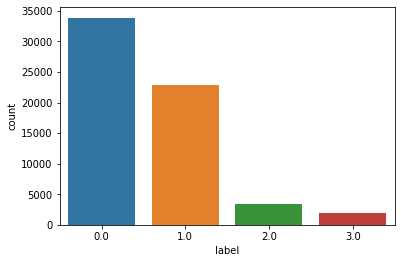

In [ ]:
import seaborn as sns
sns.countplot('label',data=df_new)

In [ ]:
df_new.shape

(62092, 2)

In [36]:
df_new["label"].replace({3: 1}, inplace=True)
df_new["label"].replace({2: 1}, inplace=True)

In [ ]:
df_new

,label,tweet
0,0.0,user father dysfunct selfish drag kid dysfunc...
1,0.0,user user thank lyft credit cant use caus dont...
2,0.0,bihday majesti
3,0.0,model love u take u time urð± ððð...
4,0.0,factsguid societi motiv
...,...,...
13401,1.0,umarfarooq faheemhus jackmjenkin exampl litera...
13418,1.0,hope someon cook drasko next ep mkr
13419,1.0,myth moder islam rebel fanat islam must outlaw
13423,1.0,loveconcursal ottomanland isi giant embarrass ...


In [37]:
final_frame=[df_new,df_only_aggression,df_only_toxic]
df_final = pd.concat(final_frame)

In [ ]:
df_final

,label,tweet
0,0.0,user father dysfunct selfish drag kid dysfunc...
1,0.0,user user thank lyft credit cant use caus dont...
2,0.0,bihday majesti
3,0.0,model love u take u time urð± ððð...
4,0.0,factsguid societi motiv
...,...,...
159644,1.0,im soori sinc googl imag allow ppl take stuff ...
159645,1.0,ever fuggin fag question know mine
159646,1.0,nice tri cigaridiot explain odocoileus vi...
159647,1.0,kys stylebackgroundcolor border solid ...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


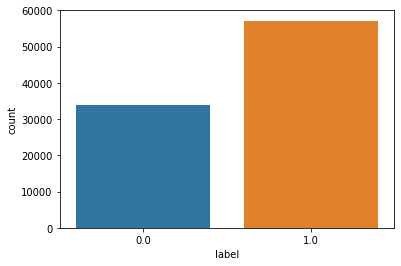

In [38]:
import seaborn as sns
sns.countplot('label',data=df_final)

In [39]:
X=df_final['tweet']
Y=df_final['label']

In [40]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y,stratify = Y,random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

68283 68283
22761 22761


In [41]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [42]:
final_model = Sequential()
final_model.add(Embedding(max_words, 100, input_length=max_len))
final_model.add(SpatialDropout1D(0.2))
final_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
final_model.add(Dense(1, activation='sigmoid'))
final_model.summary()
final_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [43]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

stop = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=5
)

checkpoint= ModelCheckpoint(
    filepath='./content/drive/MyDrive',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [44]:
final_history=final_model.fit(sequences_matrix,y_train,batch_size=1024,epochs=10,
          validation_split=0.2,callbacks=[stop,checkpoint])

Epoch 1/10
54/54 [==============================] - 101s 2s/step - loss: 0.4500 - accuracy: 0.8168 - val_loss: 0.2387 - val_accuracy: 0.9211
Epoch 2/10
54/54 [==============================] - 93s 2s/step - loss: 0.1774 - accuracy: 0.9371 - val_loss: 0.1671 - val_accuracy: 0.9381
Epoch 3/10
54/54 [==============================] - 93s 2s/step - loss: 0.1358 - accuracy: 0.9508 - val_loss: 0.1637 - val_accuracy: 0.9381
Epoch 4/10
54/54 [==============================] - 93s 2s/step - loss: 0.1098 - accuracy: 0.9600 - val_loss: 0.1508 - val_accuracy: 0.9425
Epoch 5/10
54/54 [==============================] - 93s 2s/step - loss: 0.0963 - accuracy: 0.9658 - val_loss: 0.1514 - val_accuracy: 0.9432
Epoch 6/10
54/54 [==============================] - 92s 2s/step - loss: 0.0846 - accuracy: 0.9698 - val_loss: 0.1590 - val_accuracy: 0.9390
Epoch 7/10
54/54 [==============================] - 93s 2s/step - loss: 0.0773 - accuracy: 0.9726 - val_loss: 0.1732 - val_accuracy: 0.9401
Epoch 8/10
54/54 [=

In [45]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [47]:
accr = final_model.evaluate(test_sequences_matrix,y_test)

712/712 [==============================] - 81s 113ms/step - loss: 0.1786 - accuracy: 0.9382


In [46]:
final_model.save("/content/drive/MyDrive/Final_Sentiment_Analysis.h5")

In [48]:
lstm_prediction=final_model.predict(test_sequences_matrix)

In [49]:
res=[]
for prediction in lstm_prediction:
    if prediction[0]<0.5:
        res.append(0)
    else:
        res.append(1)

In [50]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,res))

[[ 7655   816]
 [  591 13699]]


In [51]:
import pickle
with open('Final_Sentiment_Tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
with open('Final_Sentiment_Tokenizer.pickle', 'rb') as handle:
   load_tokenizer = pickle.load(handle)

In [53]:
new_model=keras.models.load_model("/content/drive/MyDrive/Final_Sentiment_Analysis.h5")

In [ ]:
with open('/content/drive/MyDrive/Final_Sentiment_Tokenizer.pickle', 'rb') as handle:
   load_tokenizer1 = pickle.load(handle)

In [71]:
test = """This shit song is crap to my ears."""
def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
test=[clean_text(test)]
print(test)
# max_words = 50000
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(test)
# seq = tokenizer.texts_to_sequences(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = sequence.pad_sequences(seq, maxlen=300)
print(seq)
pred = new_model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")

This shit song is crap to my ears.
this shit song is crap to my ears
['shit song crap ear']
[[12, 489, 339, 1937]]
pred [[0.9924015]]
pred type <class 'numpy.ndarray'>
hate and abusive
